In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from scipy.optimize import lsq_linear

# import scipy.sparse.linalg
from scipy.sparse import csr_matrix

import celeri

plt.rcParams["text.usetex"] = False

##### Read input, create data structures, close blocks


In [3]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# Hack
segment.locking_depth = 15
segment.burial_depth = 0
segment.locking_depth.values[segment.patch_flag == 1] = 0
segment.burial_depth.values[segment.patch_flag == 1] = 0

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-06-14 16:36:16.987 | INFO     | celeri.celeri:get_logger:128 - Read: ../data/command/western_north_america_command.json
2024-06-14 16:36:16.988 | INFO     | celeri.celeri:get_logger:129 - RUN_NAME: 2024-06-14-16-36-16
2024-06-14 16:36:16.989 | INFO     | celeri.celeri:get_logger:130 - Write log file: ../runs/2024-06-14-16-36-16/2024-06-14-16-36-16.log
2024-06-14 16:36:16.989 | INFO     | celeri.celeri:read_data:135 - Reading data files
2024-06-14 16:36:16.995 | SUCCESS  | celeri.celeri:read_data:139 - Read: ../data/segment/western_north_america_segment.csv
2024-06-14 16:36:16.997 | SUCCESS  | celeri.celeri:read_data:144 - Read: ../data/block/western_north_america_block.csv
2024-06-14 16:36:16.997 | SUCCESS  | celeri.celeri:read_data:151 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2024-06-14 16:36:17.024 | SUCCESS  | celeri.celeri:read_data:272 - Read: ../data/mesh/cascadia.msh
2024-06-14 16:36:17.027 | SUCCESS  | celeri.celeri:read_data:308 - Read: ../data/station/western_north_america_station.csv
2024-06-14 16:36:17.028 | INFO     | celeri.celeri:read_data:323 - No mogi_file_name
2024-06-14 16:36:17.029 | INFO     | celeri.celeri:read_data:345 - No sar_file_name


##### Get elastic operators and TDE smoothing operators


In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-06-14 16:36:17.793 | INFO     | celeri.celeri:get_elastic_operators:1530 - Using precomputed elastic operators


##### Calculate non-elastic operators


In [5]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-06-14 16:36:18.413 | INFO     | celeri.celeri:get_slip_rate_constraints:1169 - Found 1 slip rate constraints
2024-06-14 16:36:18.416 | INFO     | celeri.celeri:get_slip_rate_constraints:1172 - Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)


##### Plot input data


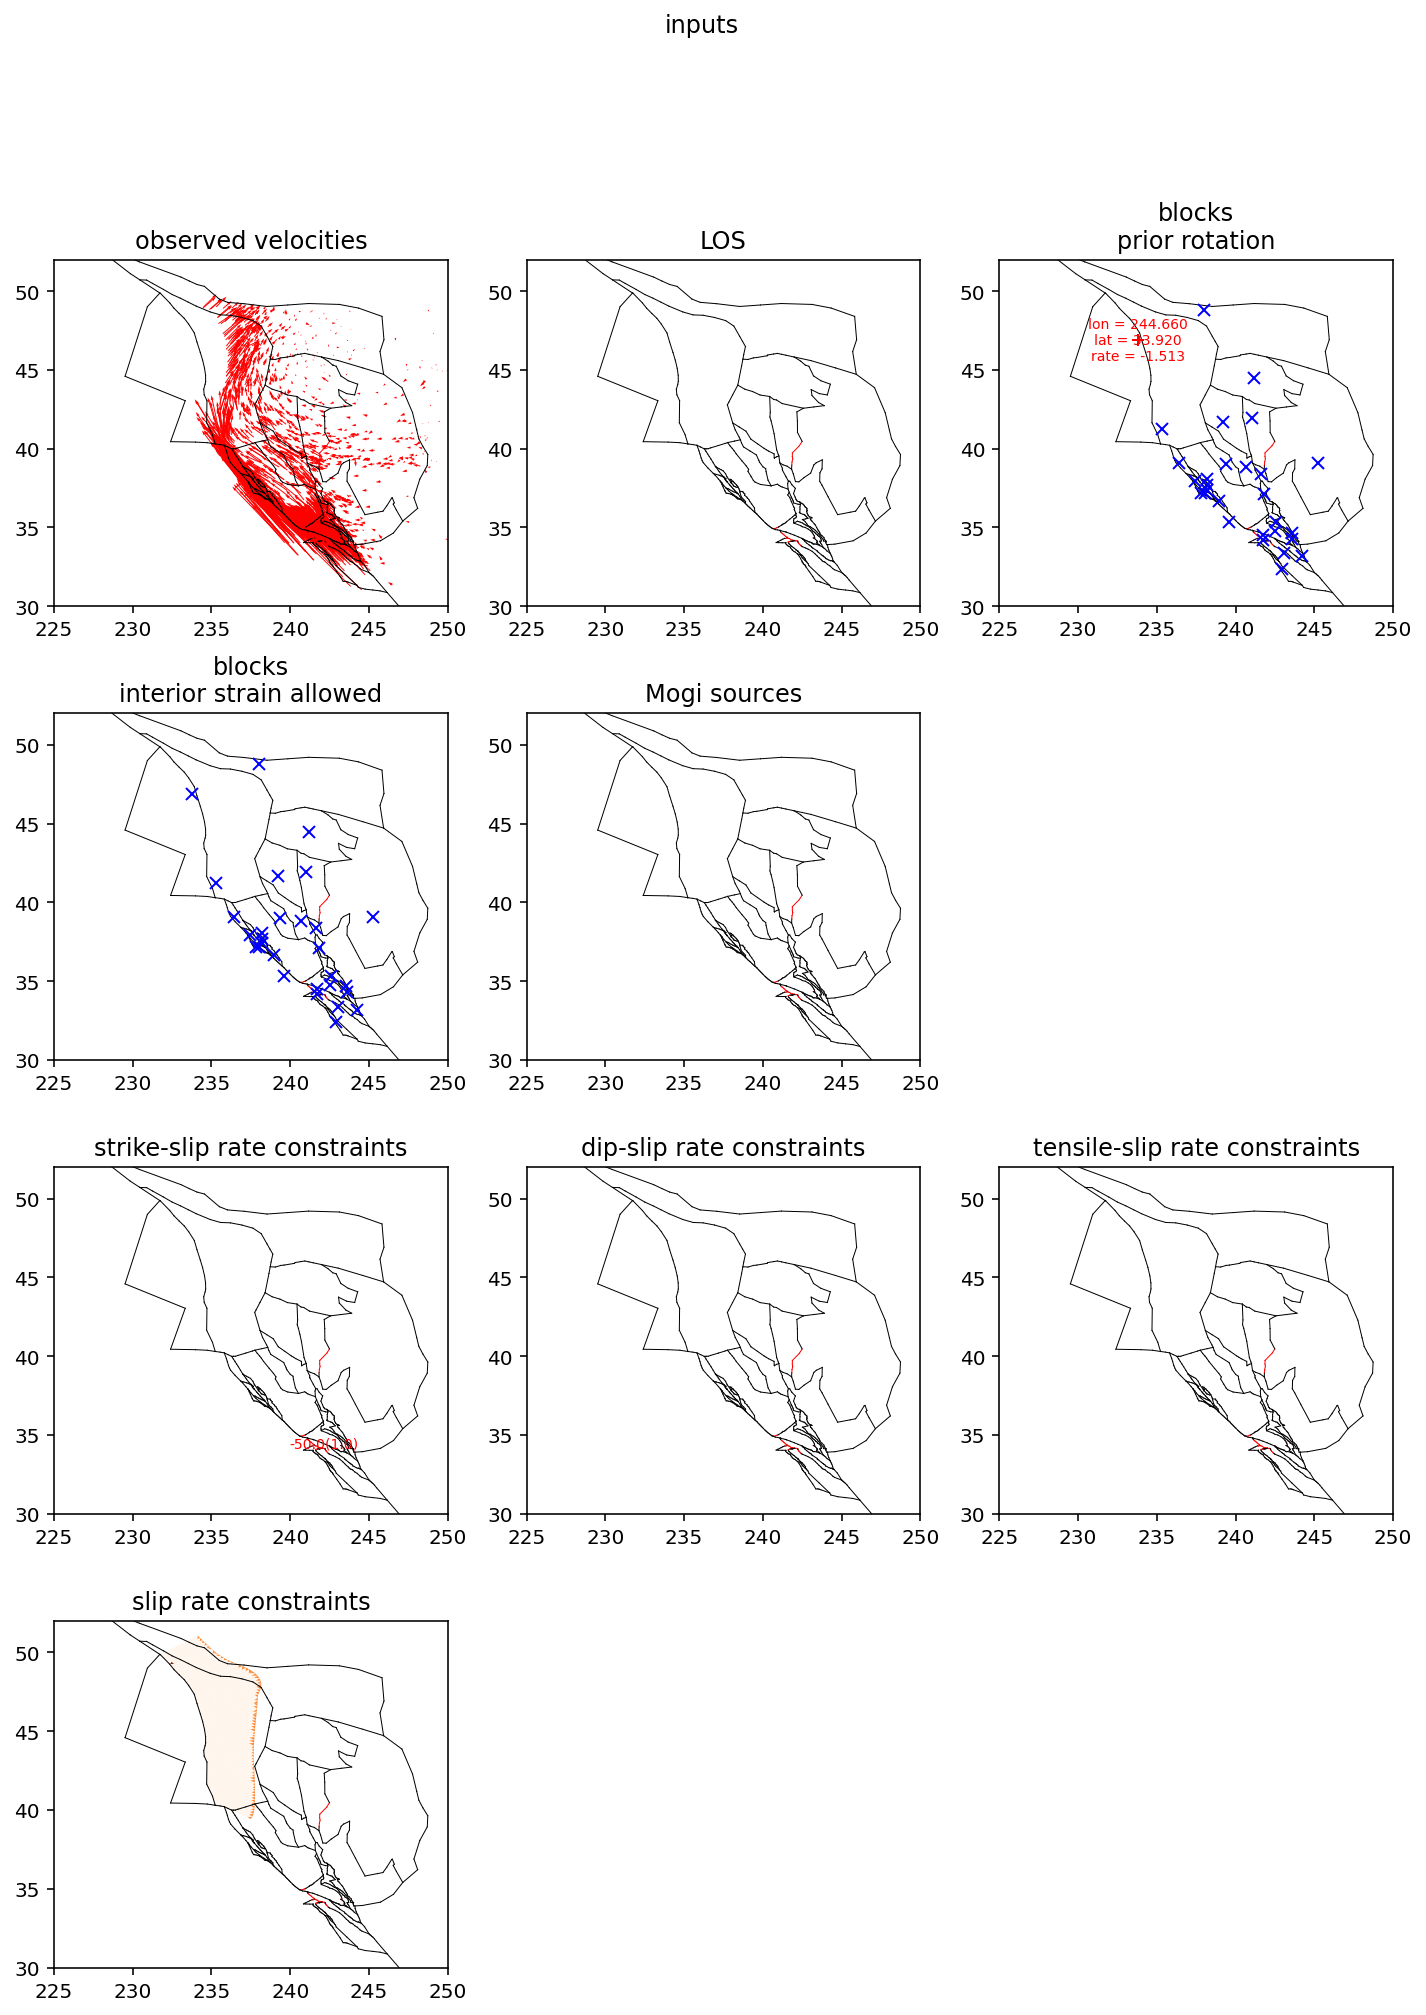

2024-06-14 16:36:22.197 | SUCCESS  | celeri.celeri:plot_input_summary:4415 - Wrote figures../runs/2024-06-14-16-36-16/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [6]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 1. Full direct dense block model solve


In [7]:
index = celeri.get_index(assembly, station, block, meshes)
estimation = addict.Dict()
estimation.data_vector = celeri.get_data_vector(assembly, index, meshes)
estimation.weighting_vector = celeri.get_weighting_vector(
    command, station, meshes, index
)
estimation.operator = celeri.get_full_dense_operator(operators, meshes, index)

# Solve the overdetermined linear system using only a weighting vector rather than matrix
tic = time.time()
estimation.state_covariance_matrix = np.linalg.inv(
    estimation.operator.T * estimation.weighting_vector @ estimation.operator
)
estimation.state_vector = (
    estimation.state_covariance_matrix
    @ estimation.operator.T
    * estimation.weighting_vector
    @ estimation.data_vector
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

Elapsed time: 1.9471909999847412


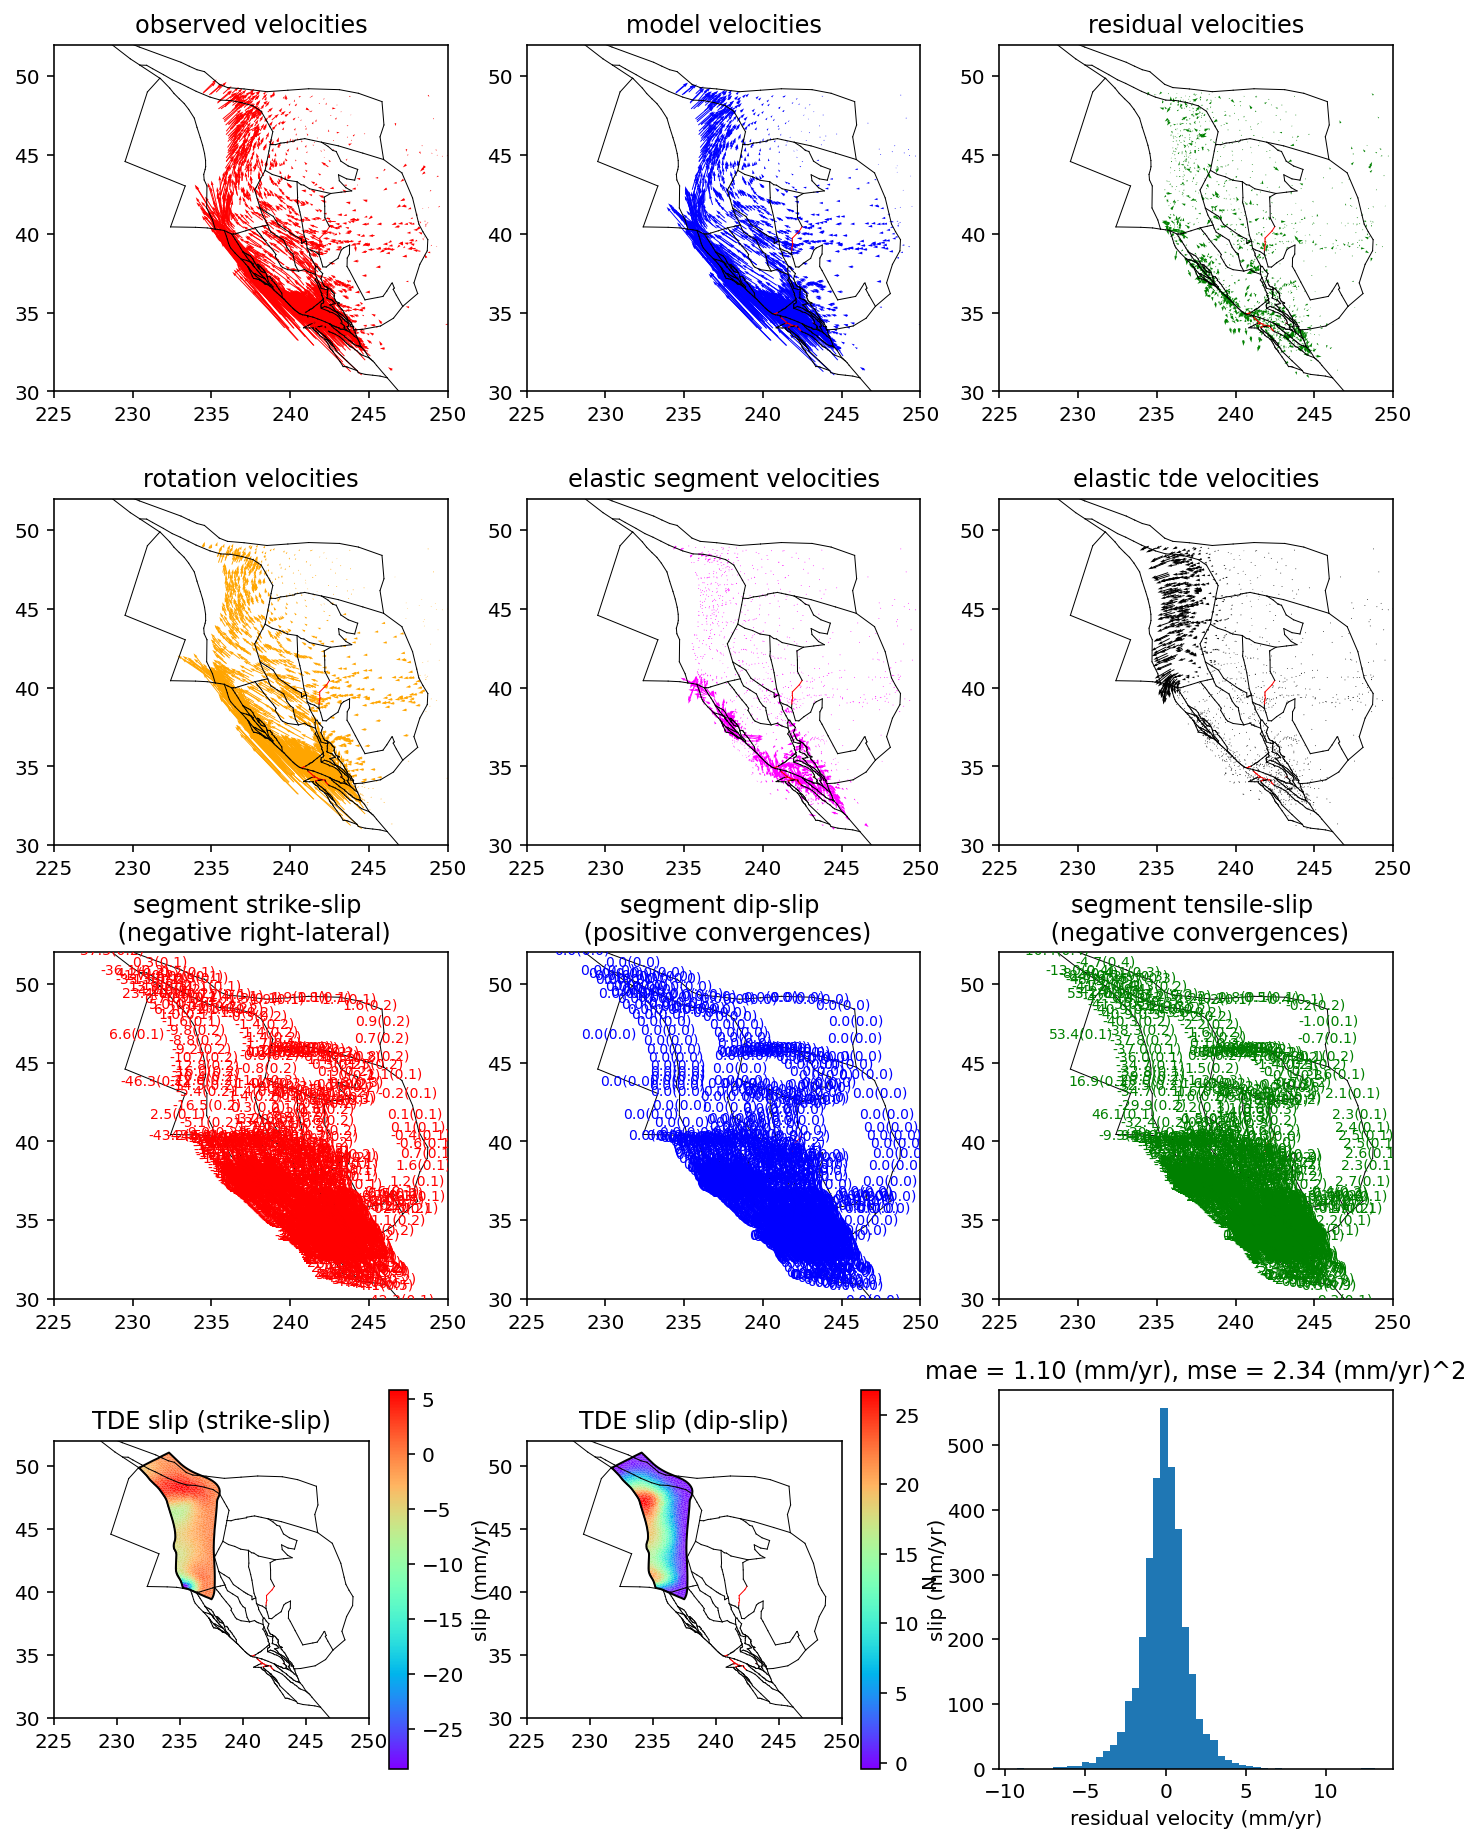

2024-06-14 16:36:32.233 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-14-16-36-16/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [8]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 2. Bounded full dense solve with `lsq_linear`

In [9]:
# Bounded full solve with lsq_linear

lower_bound = np.zeros_like(estimation.state_vector)
upper_bound = np.zeros_like(estimation.state_vector)
lower_bound[:] = -np.inf
upper_bound[:] = np.inf

# Strike-slip
lower_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = -5
upper_bound[index.start_tde_col[0] : index.end_tde_col[0] : 2] = 5

# Dip-slip
lower_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 0
upper_bound[index.start_tde_col[0] + 1 : index.end_tde_col[0] : 2] = 30

# Non-linear solver (bounded [-inf, inf])
tic = time.time()
res = lsq_linear(
    estimation.operator * np.sqrt(estimation.weighting_vector[:, None]),
    estimation.data_vector * np.sqrt(estimation.weighting_vector),
    bounds=(lower_bound, upper_bound),
    verbose=1,
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

estimation_bounded = copy.deepcopy(estimation)
estimation_bounded.state_vector = res.x
celeri.post_process_estimation(estimation_bounded, operators, station, index)

The maximum number of iterations is exceeded.
Number of iterations 100, initial cost 1.8103e+04, final cost 1.2313e+04, first-order optimality 2.02e+07.
Elapsed time: 463.19113516807556


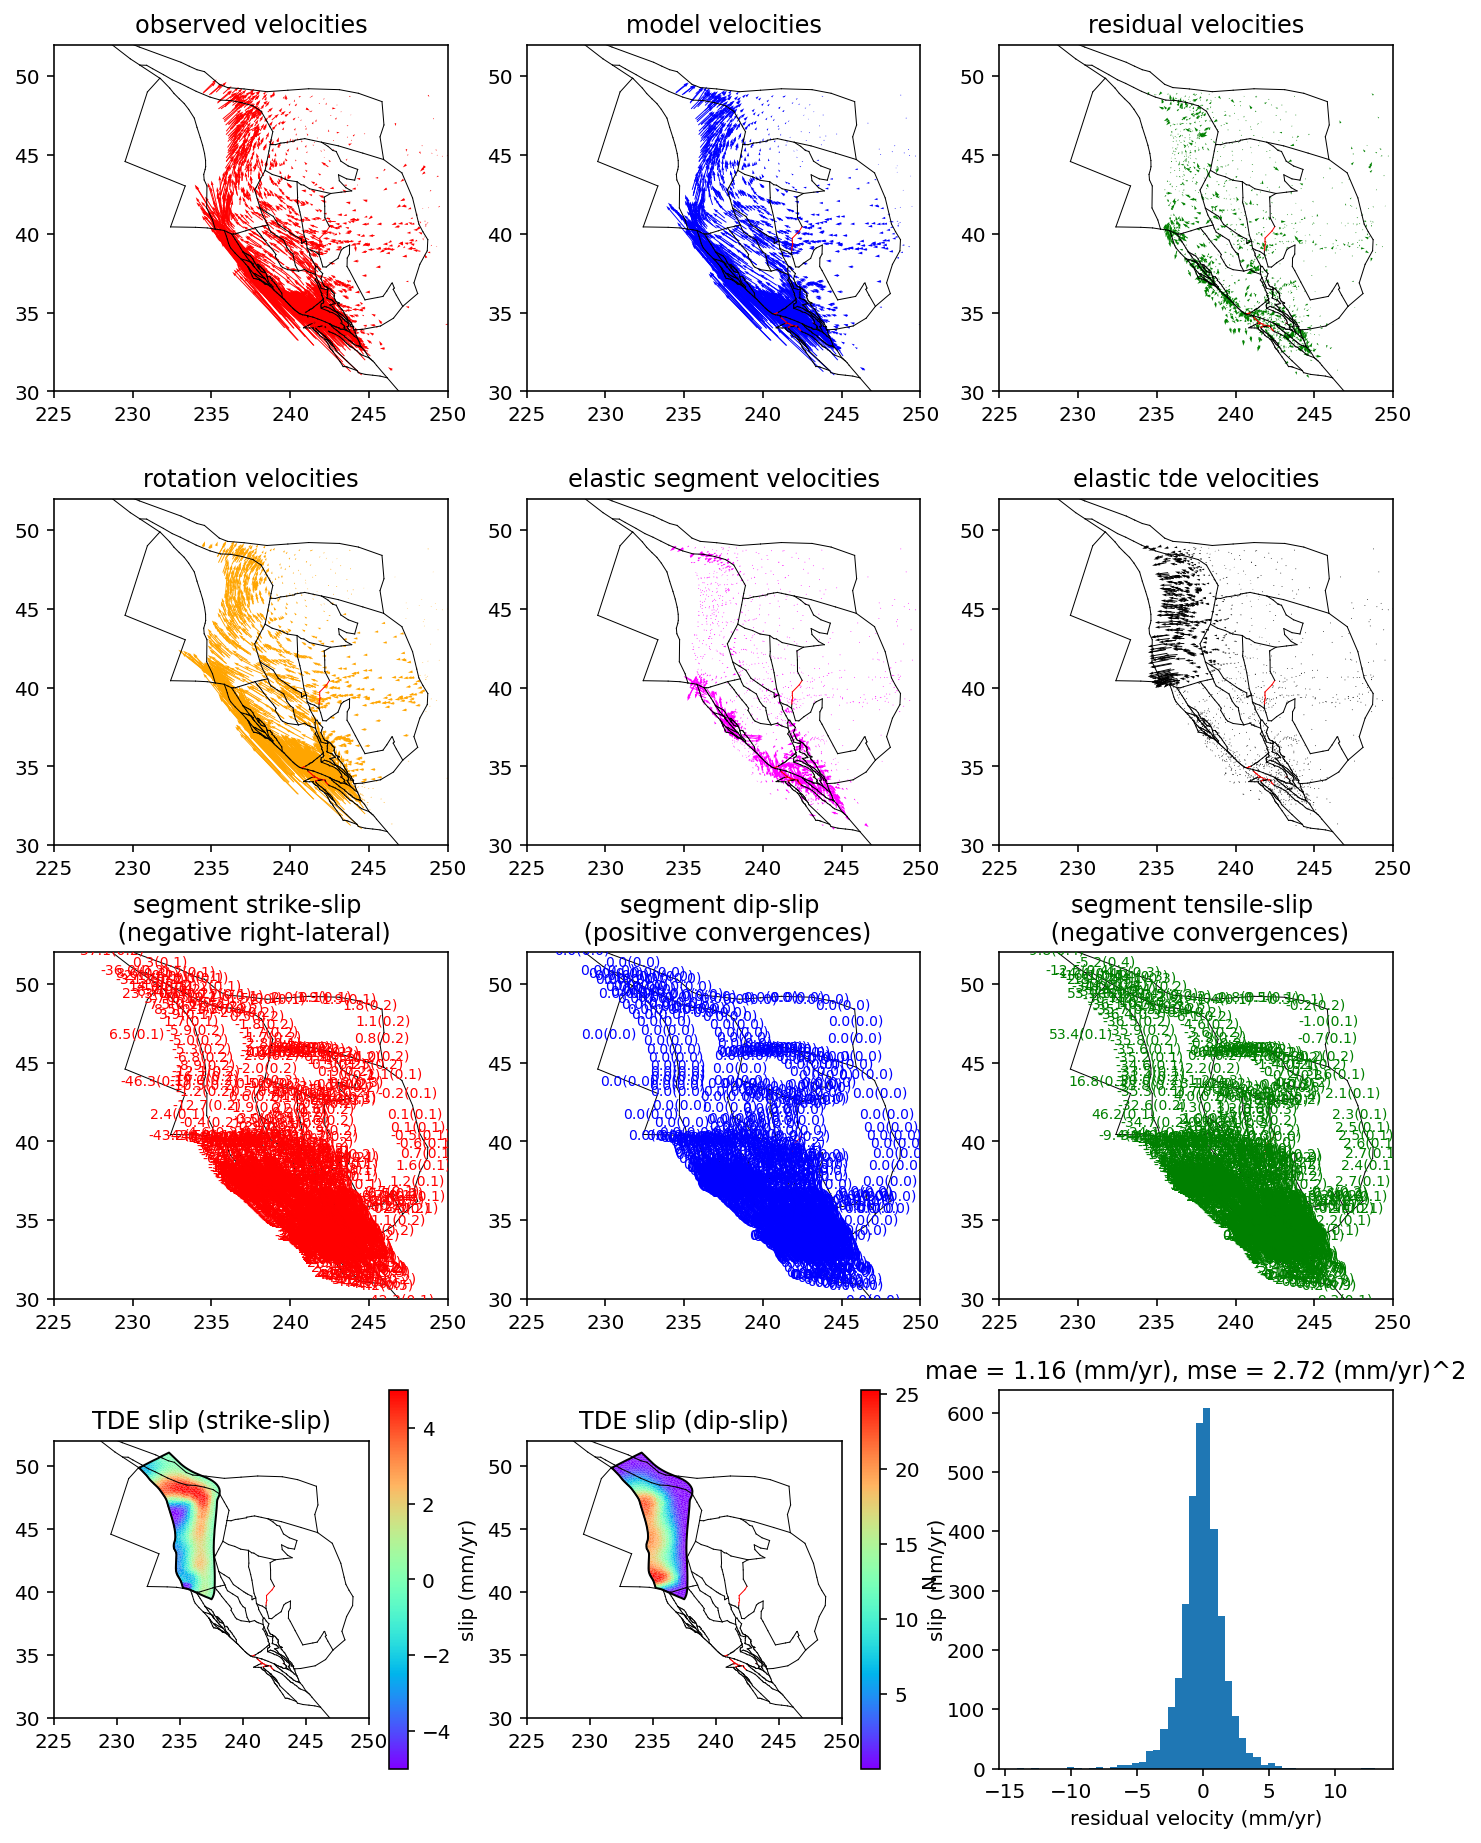

2024-06-14 16:44:22.651 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-14-16-36-16/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [10]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_bounded,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# 3. Dense KL solve

In [11]:
import scipy


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


# Calculate eigenvales and eigenvectors for triangle subset
# n_eigenvalues = meshes[0].n_tde
# n_eigenvalues = 20


eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    meshes[0].n_eigen,
    meshes[0].x_centroid,
    meshes[0].y_centroid,
    meshes[0].z_centroid,
)

In [12]:
# Create modified eigenvector matrix here
# This is a replication of the EVs for both slip components
# There are other ways to do this but as implemented is a sort of
# checkerboard like pattern.  The column indexing an every other
# row striding implements this.
eigenvectors_two_component = np.zeros(
    (2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1])
)
for i in range(meshes[0].n_eigen):
    index_column_1 = 2 * i
    index_column_2 = 2 * i + 1
    eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
    eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]

In [13]:
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6  # TODO: What should this conversion be?


def get_data_vector_eigen(assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_smoothing_row[i] : index.start_tde_smoothing_row[i]
            + index.n_tde_constraints[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator

    n_eigen = eigenvectors_two_component.shape[1] / 2
    print(f"{n_eigen=}")

    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            # + 2 * index.n_tde_total
            + index.n_tde_constraints_total,
            3 * index.n_blocks + 2 * int(n_eigen),
        )
    )
    print(f"{eigenvectors_two_component.shape=}")
    print(f"{operator.shape=}")

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # Insert eigenvector to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[0]
    )
    tde_keep_col_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[1]
    )
    eigen_to_velocities = (
        -operators.tde_to_velocities[0][tde_keep_row_index, :][:, tde_keep_col_index]
        @ eigenvectors_two_component
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_velocities

    # Insert eigenvector to TDE constraints matrix
    # TODO: Inherit weighting from mesh_parameters file
    NNN = 1e1
    eigen_to_tde_slip_rate_constraints = (
        NNN * operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component
    )

    operator[
        index.start_slip_rate_constraints_row : index.start_slip_rate_constraints_row
        + index.n_tde_constraints_total,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_tde_slip_rate_constraints

    # # Insert TDE to velocity matrix
    # for i in range(len(meshes)):
    #     # Insert TDE to velocity matrix
    #     tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    #     tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    #     operator[
    #         index.start_station_row : index.end_station_row,
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = -operators.tde_to_velocities[i][tde_keep_row_index, :][
    #         :, tde_keep_col_index
    #     ]

    #     # # Insert TDE smoothing matrix
    #     # smoothing_keep_index = celeri.get_keep_index_12(
    #     #     operators.tde_to_velocities[i].shape[1]
    #     # )
    #     # operator[
    #     #     index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i],
    #     #     index.start_tde_col[i] : index.end_tde_col[i],
    #     # ] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][
    #     #     :, smoothing_keep_index
    #     # ]

    #     # Insert TDE slip rate constraints into estimation operator
    #     operator[
    #         index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i],
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = operators.tde_slip_rate_constraints[i]
    return operator


data_vector = celeri.get_data_vector(assembly, index, meshes)
data_vector_eigen = get_data_vector_eigen(assembly, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator = celeri.get_full_dense_operator(operators, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)

n_eigen=20.0
eigenvectors_two_component.shape=(3682, 40)
operator.shape=(3519, 133)


In [14]:
def post_process_estimation_eigen(
    estimation_eigen: Dict, operators: Dict, station: pd.DataFrame, index: Dict
):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    # TODO: Start working through this for the EV case
    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    estimation_eigen.slip_rate_sigma = np.sqrt(
        np.diag(
            operators.rotation_to_slip_rate
            @ estimation_eigen.state_covariance_matrix[
                0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
            ]
            @ operators.rotation_to_slip_rate.T
        )
    )  # I don't think this is correct because for the case when there is a rotation vector a priori
    estimation_eigen.strike_slip_rate_sigma = estimation_eigen.slip_rate_sigma[0::3]
    estimation_eigen.dip_slip_rate_sigma = estimation_eigen.slip_rate_sigma[1::3]
    estimation_eigen.tensile_slip_rate_sigma = estimation_eigen.slip_rate_sigma[2::3]

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]
    )
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):

        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )
        estimation_eigen.vel_tde += (
            operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
            @ eigenvectors_two_component
            @ estimation_eigen.state_vector[
                index.start_tde_col[i] : index.end_tde_col[i]
            ]
            # @ estimation_eigen.eigenvalues
        )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]


# Solve the linear system
estimation_eigen = addict.Dict()
tic = time.time()
estimation_eigen.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen.state_vector = (
    estimation_eigen.state_covariance_matrix
    @ operator_eigen.T
    * weighting_vector_eigen
    @ data_vector_eigen
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

forward_data_vector_eigen = operator_eigen @ estimation_eigen.state_vector

estimation_eigen.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen, operators, station, index)

Elapsed time: 0.00368499755859375


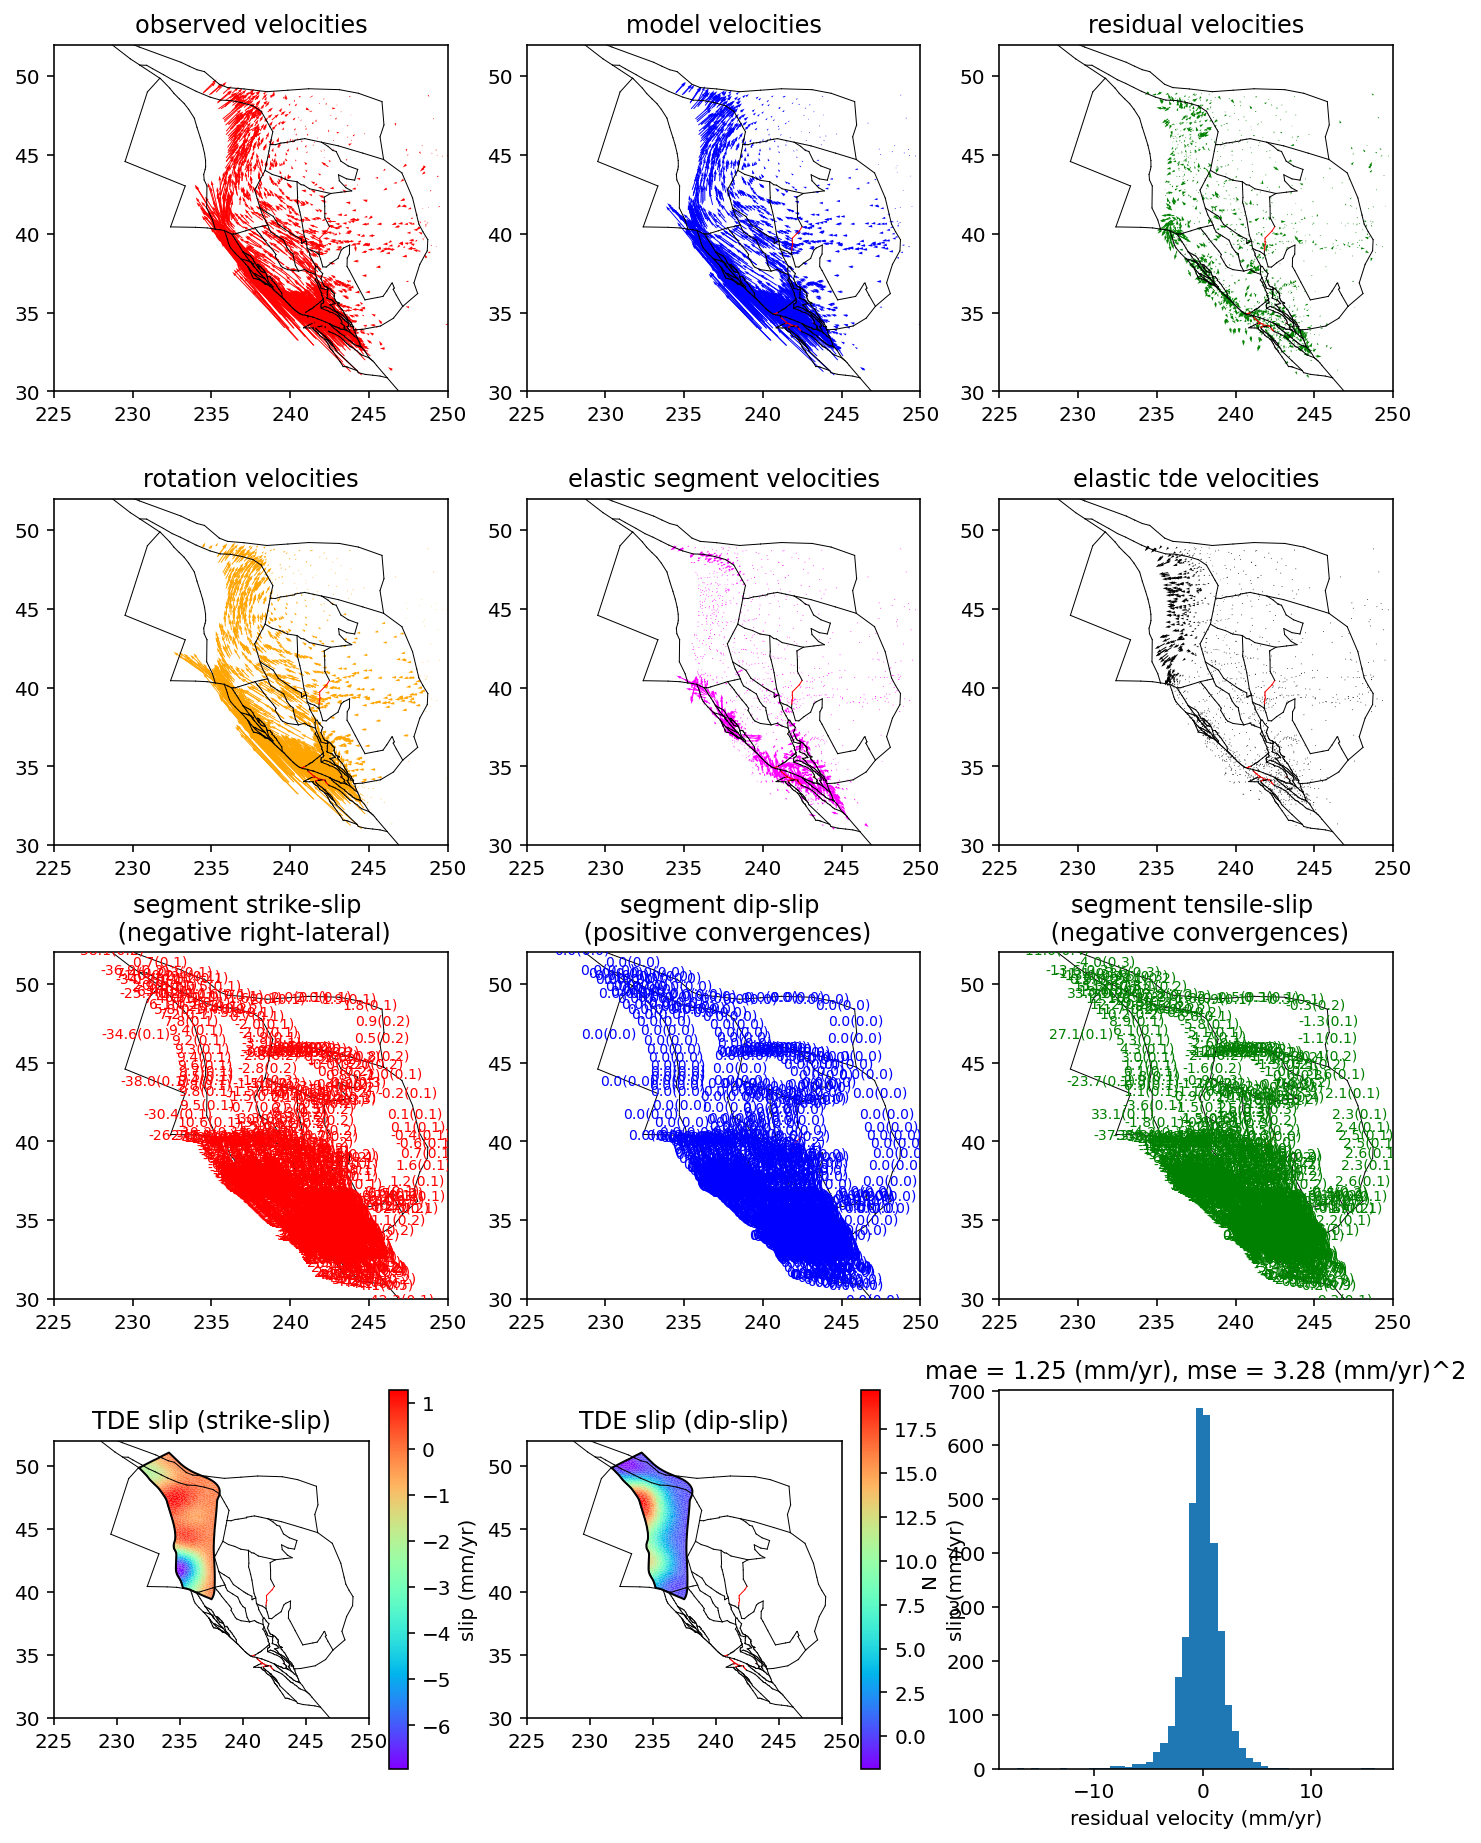

2024-06-14 16:44:31.616 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-14-16-36-16/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [15]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 4. H-matrix solve

##### Calculate col_norms and H for each mesh here.

In [16]:
# Data and data weighting vector
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
data_vector = celeri.get_data_vector(assembly, index, meshes)

# Apply data weighting
data_vector = data_vector * np.sqrt(weighting_vector)

from celeri.hmatrix import build_hmatrix_from_mesh_tdes

# Cast all block submatrices to sparse
sparse_block_motion_okada_faults = csr_matrix(
    operators.rotation_to_velocities[index.station_row_keep_index, :]
    - operators.rotation_to_slip_rate_to_okada_to_velocities[
        index.station_row_keep_index, :
    ]
)
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

# Calculate column normalization vector for blocks
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector_block_only = weighting_vector[0 : operator_block_only.shape[0]][
    :, None
]
col_norms = np.linalg.norm(
    operator_block_only * np.sqrt(weighting_vector_block_only), axis=0
)


# Create lists for all TDE matrices per mesh
H = []
for i in range(len(meshes)):
    # Get full TDE to velocity matrix for current mesh
    tde_to_velocities = celeri.get_elastic_operator_single_mesh(
        meshes, station, command, i
    )

    # H-matrix representation
    H.append(
        build_hmatrix_from_mesh_tdes(
            meshes[i],
            station,
            -tde_to_velocities,
            1e-6,
            min_separation=1.25,
            min_pts_per_box=20,
        )
    )
    print(
        f"mesh {i} ({meshes[i].name}) H-matrix compression ratio: {H[i].report_compression_ratio():0.4f}"
    )

    # Cast smoothing matrices and tde slip rate constraints to sparse
    smoothing_keep_index = celeri.get_keep_index_12(
        operators.smoothing_matrix[i].shape[0]
    )
    operators.smoothing_matrix[i] = csr_matrix(
        operators.smoothing_matrix[i][smoothing_keep_index, :][:, smoothing_keep_index]
    )
    operators.tde_slip_rate_constraints[i] = csr_matrix(
        operators.tde_slip_rate_constraints[i]
    )

    # Eliminate unused columns and rows of TDE to velocity matrix
    tde_to_velocities = np.delete(
        tde_to_velocities, np.arange(2, tde_to_velocities.shape[0], 3), axis=0
    )
    tde_to_velocities = np.delete(
        tde_to_velocities, np.arange(2, tde_to_velocities.shape[1], 3), axis=1
    )

    # Calculate column normalization vector current TDE mesh
    weighting_vector_no_zero_rows = (
        celeri.get_weighting_vector_single_mesh_for_col_norms(
            command, station, meshes, index, i
        )
    )
    current_tde_mesh_columns_full_no_zero_rows = np.vstack(
        (
            -tde_to_velocities,
            operators.smoothing_matrix[i].toarray(),
            operators.tde_slip_rate_constraints[i].toarray(),
        )
    ) * np.sqrt(weighting_vector_no_zero_rows[:, None])

    # Concatenate everthing we need for col_norms
    col_norms_current_tde_mesh = np.linalg.norm(
        current_tde_mesh_columns_full_no_zero_rows, axis=0
    )
    col_norms = np.hstack((col_norms, col_norms_current_tde_mesh))
    print(col_norms.shape)

2024-06-14 16:44:31.656 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3676 - Using precomputed elastic operators
2024-06-14 16:44:31.711 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3703 - Saving elastic to velocity matrices to :../data/operators/western_north_america_elastic_operators.hdf5
mesh 0 ({}) H-matrix compression ratio: 0.3364
(3775,)


In [17]:
def matvec(v):
    """Build matvec (matrix vector product) operator for
    scipy.sparse.linalg.LinearOperator.  This returns A * u

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: This will depend on how we integrate this into celeri and which
    variable we're talking about. For example, we should stop using X.shape
    entirely because that matrix won't exist in a fully sparse/hmatrix
    implementation!
    One design that I would probably lean towards
    would be something like:
    def build_sparse_hmatrix_linear_operator(operators,...):
        sparse_block_motion_okada_faults = ...
        define_other_precomputable_vars_here = ...

        def matvec(v):
            # use vars from the outer scope
        def rmatvec(v):
            # use vars from the outer scope

        return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)

    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    # TBT: It's important to remember to keep the input and output weighting
    # conceptually separate since the "out * np.sqrt(W)" will actually change
    # the solution to the least squares problem whereas the "v / col_norms"
    # preconditioning step is a reversible change to the solution (which is the
    # point since preconditioning should not change the solution!!)
    v_scaled = v / col_norms

    # Make storage for output
    # out = np.zeros(X.shape[0])
    out = np.zeros(index.n_operator_rows)
    block_rotations = v_scaled[index.start_block_col : index.end_block_col]

    # Okada
    out[
        index.start_station_row : index.end_station_row
    ] += sparse_block_motion_okada_faults.dot(block_rotations)

    # Block motion constraints
    out[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] += sparse_block_motion_constraints.dot(block_rotations)

    # Slip rate constraints
    out[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] += sparse_block_slip_rate_constraints.dot(block_rotations)

    # Loop over TDE meshes
    # for i in range(len(meshes)):
    for i in range(len(meshes)):
        tde_velocities = v_scaled[index.start_tde_col[i] : index.end_tde_col[i]]

        # Insert TDE to velocity matrix
        out[index.start_station_row : index.end_station_row] += H[i].dot(tde_velocities)

        # TDE smoothing
        out[
            index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]
        ] += operators.smoothing_matrix[i].dot(tde_velocities)

        # TDE slip rate constraints
        out[
            index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]
        ] += operators.tde_slip_rate_constraints[i].dot(tde_velocities)

    # Weight!
    return out * np.sqrt(weighting_vector)

In [18]:
def rmatvec(u):
    """Build rmatvec (matrix vector product) operator for
    scipy.sparse.linalg.LinearOperator.  This returns:
    Returns A^H * v, where A^H is the conjugate transpose of A
    for a candidate state vector, u.  We do this because
    with the h-matrix approach we no longer have the full matrix
    so we can't take the transpose all at once.

    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # Weight the data vector
    u_weighted = u * np.sqrt(weighting_vector)

    # Storage for output
    # out = np.zeros(X.shape[1])
    out = np.zeros(index.n_operator_cols)

    # Select subset of weighted data for the observed velocities
    station_rows = u_weighted[index.start_station_row : index.end_station_row]
    block_constraints = u_weighted[
        index.start_block_constraints_row : index.end_block_constraints_row
    ]

    # Select subset of weighted data for the fault slip rate constraints
    slip_rate_constraints = u_weighted[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ]

    # Okada and block rotation contribution to data vector
    out[index.start_block_col : index.end_block_col] += (
        station_rows @ sparse_block_motion_okada_faults
    )

    # Block motion constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += (
        block_constraints @ sparse_block_motion_constraints
    )

    # Fault slip rate constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += (
        slip_rate_constraints @ sparse_block_slip_rate_constraints
    )

    for i in range(len(meshes)):
        # Select subset of weighted data for the TDE smoothing
        tde_smoothing = u_weighted[
            index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]
        ]

        # Select subset of weighted data for the TDE slip rate constraints
        tde_slip_rate = u_weighted[
            index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]
        ]

        # Hmatrix (TDEs to velocities)
        out[index.start_tde_col[i] : index.end_tde_col[i]] += H[i].transpose_dot(
            station_rows
        )

        # TDE smoothing contribution to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += (
            tde_smoothing @ operators.smoothing_matrix[i]
        )

        # TDE slip rate constraint contributions to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += (
            tde_slip_rate @ operators.tde_slip_rate_constraints[i]
        )

    # Weight
    return out / col_norms

##### CRITICAL: Set `atol` value

In [19]:
print(command.atol)
command.atol = 1e-10
print(command.atol)

0.0001
1e-10


In [20]:
# Instantiate the scipy the linear operator for the iterative solver to use
operator_hmatrix = scipy.sparse.linalg.LinearOperator(
    (index.n_operator_rows, index.n_operator_cols), matvec=matvec, rmatvec=rmatvec
)

# Solve the linear system
tic = time.time()
sparse_hmatrix_solution = scipy.sparse.linalg.lsmr(
    operator_hmatrix, data_vector, atol=command.atol
)
toc = time.time()
print(f"Elapsed time: {toc - tic}")

# Correct the solution for the col_norms preconditioning.
sparse_hmatrix_state_vector = sparse_hmatrix_solution[0] / col_norms

Elapsed time: 25.081745862960815


You can look at the details of the sparse solution. There's documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsmr.html of what the return codes and outputs mean.

Return code 2 means that the solver is stopping because it has reached atol. For a "inconsistent" linear system (one where there is no exact solution), the termination condition is:

```
norm(A^H r) <= atol * norm(A) * norm(r)
```

This means:
1. `btol` doesn't do anything in the celeri context. Don't bother with it!
2. The size of `norm(A^H r)` will depend on `norm(A)` and `norm(b)` the residual entries will be 
Because norm(x) is 2189 and norm(A) is 42, then `atol` of `0.0001` will leave a lot of individual residual entries that are quite large. 
1. Because we divide by `col_norms` after solving, the bimodal distribution of `col_norms` 
2. I think this means that, when `atol` is too large, some of the TDE smoothing/constraints will not be fully satisfied. 
3. I would suggest checking how much actual influence this has on the final solution a bit more since it still seems like it'd be fine to use loose tolerances for debugging and then use something like 1e-8 or 1e-10 for a final solution. 
4. The convergence should be quite fast so it should only take 2x or 3x longer to get to a very small tolerance.


In [21]:
sparse_hmatrix_solution

(array([  6.31635522,   6.77756306, -22.74042213, ...,  -0.13578855,
          0.80742683,  -0.23430888]),
 2,
 3099,
 146.57969123723603,
 1.046144928918607e-06,
 71.57308820121914,
 16.285146733928784,
 26406833.56134302)

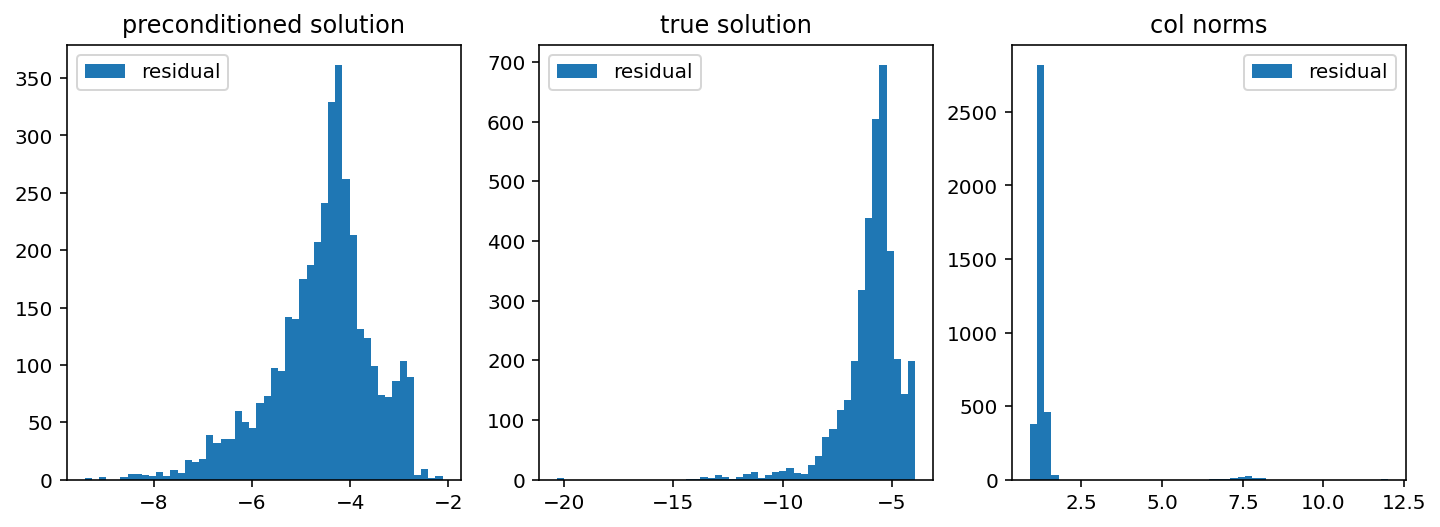

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(
    np.log10(
        np.abs(
            estimation.state_vector * col_norms
            - sparse_hmatrix_state_vector * col_norms
        )
    ),
    50,
    label="residual",
)
plt.title(f"preconditioned solution")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(
    np.log10(np.abs(estimation.state_vector - sparse_hmatrix_state_vector)),
    50,
    label="residual",
)
plt.title(f"true solution")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(np.log10(col_norms), 50, label="residual")
plt.title(f"col norms")
plt.legend()
plt.show()

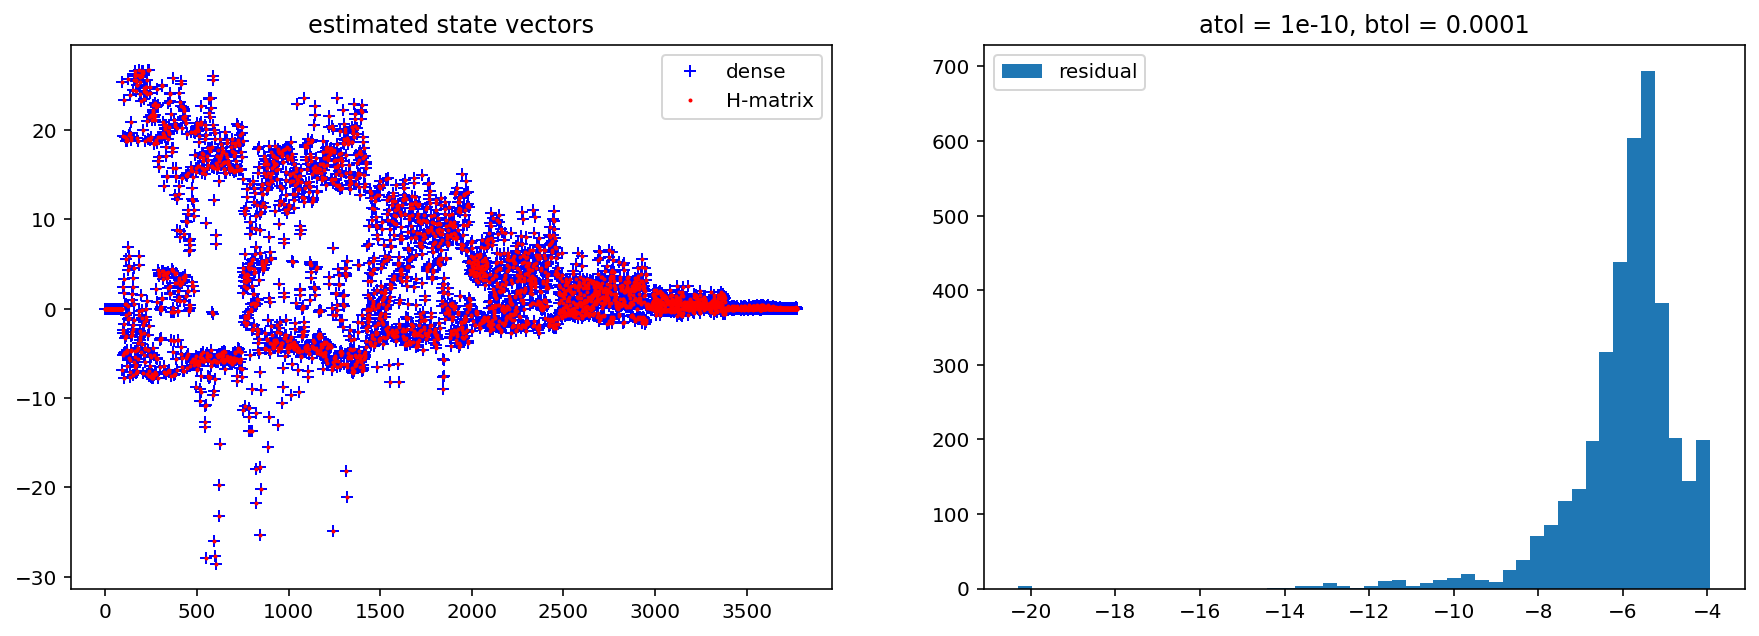

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(estimation.state_vector, "+b", label="dense")
plt.plot(sparse_hmatrix_state_vector, "r.", markersize=2, label="H-matrix")
plt.legend()
plt.title("estimated state vectors")

plt.subplot(1, 2, 2)
plt.hist(
    np.log10(np.abs(estimation.state_vector - sparse_hmatrix_state_vector)),
    50,
    label="residual",
)
plt.title(f"atol = {command.atol}, btol = {command.btol}")
plt.legend()
plt.show()

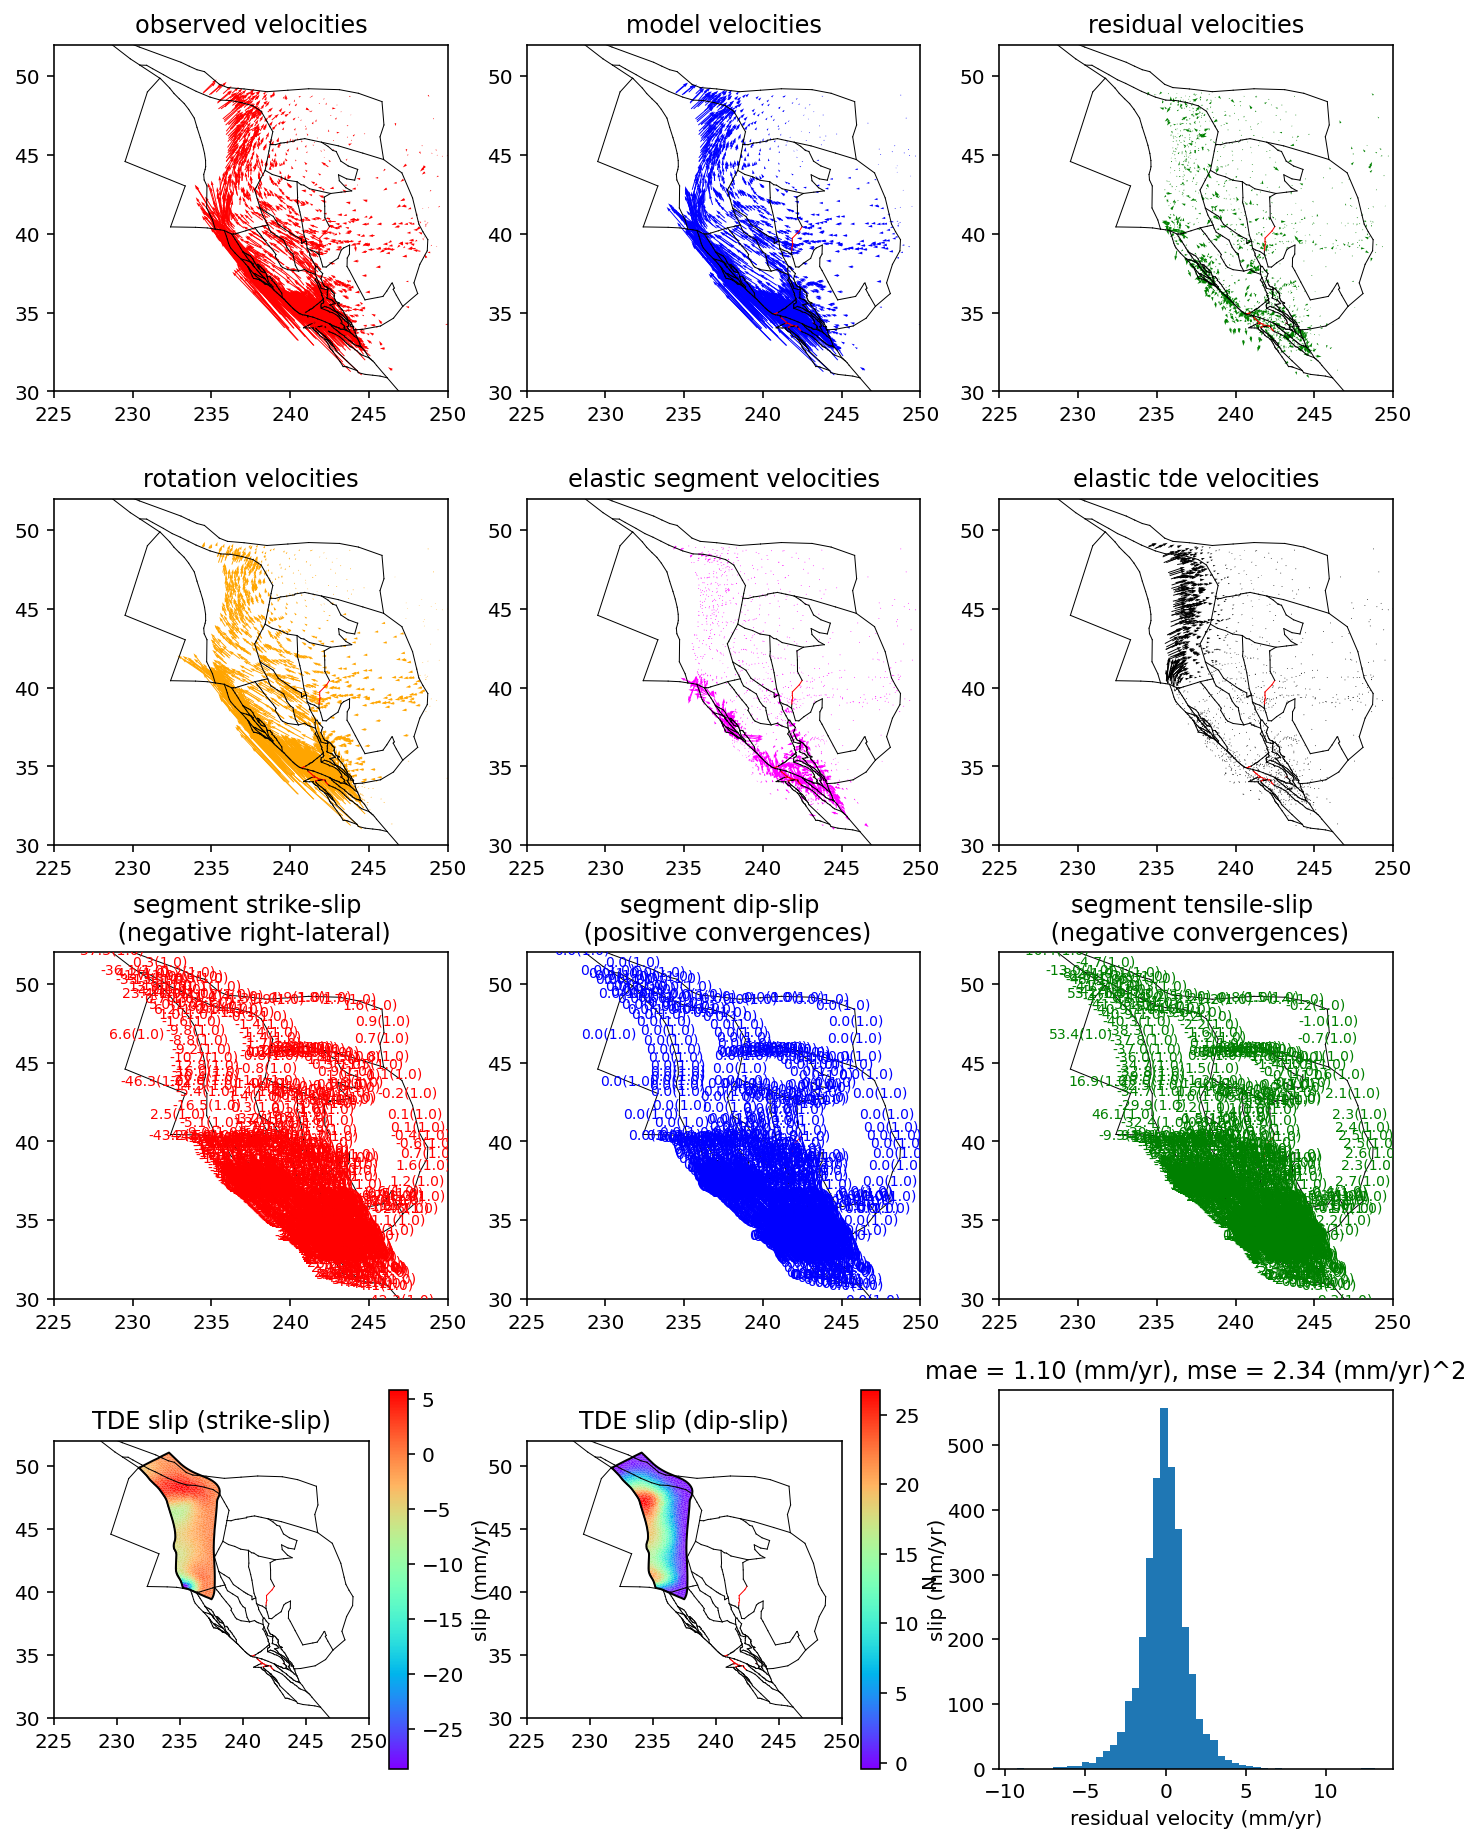

2024-06-14 16:45:07.137 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-14-16-36-16/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [24]:
def post_process_estimation_hmatrix(
    estimation_hmatrix: Dict, operators: Dict, station: pd.DataFrame, index: Dict
):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        index (Dict): Indices and counts of data and array sizes
    """

    estimation_hmatrix.predictions = matvec(
        estimation_hmatrix.state_vector * col_norms
    ) / np.sqrt(weighting_vector)
    estimation_hmatrix.vel = estimation_hmatrix.predictions[0 : 2 * index.n_stations]
    estimation_hmatrix.east_vel = estimation_hmatrix.vel[0::2]
    estimation_hmatrix.north_vel = estimation_hmatrix.vel[1::2]

    # Calculate mean squared residual velocity
    estimation_hmatrix.east_vel_residual = (
        estimation_hmatrix.east_vel - station.east_vel
    )
    estimation_hmatrix.north_vel_residual = (
        estimation_hmatrix.north_vel - station.north_vel
    )

    # Extract TDE slip rates from state vector
    estimation_hmatrix.tde_rates = estimation_hmatrix.state_vector[
        3 * index.n_blocks : 3 * index.n_blocks + 2 * index.n_tde_total
    ]
    estimation_hmatrix.tde_strike_slip_rates = estimation_hmatrix.tde_rates[0::2]
    estimation_hmatrix.tde_dip_slip_rates = estimation_hmatrix.tde_rates[1::2]

    # Extract segment slip rates from state vector
    estimation_hmatrix.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_hmatrix.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_hmatrix.strike_slip_rates = estimation_hmatrix.slip_rates[0::3]
    estimation_hmatrix.dip_slip_rates = estimation_hmatrix.slip_rates[1::3]
    estimation_hmatrix.tensile_slip_rates = estimation_hmatrix.slip_rates[2::3]

    estimation_hmatrix.strike_slip_rate_sigma = np.ones_like(
        estimation_hmatrix.strike_slip_rates
    )
    estimation_hmatrix.dip_slip_rate_sigma = np.ones_like(
        estimation_hmatrix.dip_slip_rates
    )
    estimation_hmatrix.tensile_slip_rate_sigma = np.ones_like(
        estimation_hmatrix.tensile_slip_rates
    )

    # Calculate rotation only velocities
    estimation_hmatrix.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_hmatrix.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_hmatrix.east_vel_rotation = estimation_hmatrix.vel_rotation[0::2]
    estimation_hmatrix.north_vel_rotation = estimation_hmatrix.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_hmatrix.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_hmatrix.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_hmatrix.east_vel_elastic_segment = (
        estimation_hmatrix.vel_elastic_segment[0::2]
    )
    estimation_hmatrix.north_vel_elastic_segment = (
        estimation_hmatrix.vel_elastic_segment[1::2]
    )

    # TODO: Calculate block strain rate velocities
    estimation_hmatrix.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_hmatrix.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_hmatrix.vel_tde = np.zeros(2 * index.n_stations)
    # for i in range(len(operators.tde_to_velocities)):
    for i in range(len(meshes)):

        estimation_hmatrix.vel_tde += H[i].dot(
            estimation.state_vector[index.start_tde_col[i] : index.end_tde_col[i]]
        )
    estimation_hmatrix.east_vel_tde = estimation_hmatrix.vel_tde[0::2]
    estimation_hmatrix.north_vel_tde = estimation_hmatrix.vel_tde[1::2]


estimation_hmatrix = addict.Dict()
estimation_hmatrix.data_vector = data_vector
estimation_hmatrix.weighting_vector = weighting_vector
estimation_hmatrix.operator = operator_hmatrix
estimation_hmatrix.state_vector = sparse_hmatrix_state_vector
post_process_estimation_hmatrix(estimation_hmatrix, operators, station, index)
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_hmatrix,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# 5. Iterative dense solve with adaptive constraints

# 6. Iterative KL solve with adaptive constraints

# 7. H-matrix with `lsq_linear`